# SyMBac Example Notebook 1

Drawing 100x images of _E. coli_ in the mother machine

### Imports

In [1]:
from SyMBac.phase_contrast_drawing import *
from SyMBac.PSF import get_phase_contrast_kernel, get_condensers
from SyMBac.misc import get_sample_images
import napari

import numpy as np
from ipywidgets import interactive, fixed
from tqdm.notebook import tqdm

import importlib
if importlib.util.find_spec("cupy") is None:
    manual_update = True
else:
    manual_update = False

## Load a real image

* Make sure this image is somewhat representative of the data you want to simulate. The simulated data will have the same dimensions as the example image.
* Also you will try to match the similarity of your synthetic images to this real image.

(256, 46)


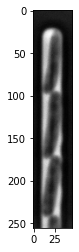

In [11]:
real_image = get_sample_images()["E. coli 100x"]
print(real_image.shape)
plt.imshow(real_image,cmap="Greys_r")
plt.show()

## Scope properties

Here we input the scope properties:
* `W`, `R` and `diameter` are the dimensions (in mm) of the phase ring, retrieved from `get_condensers()`.
* `λ` is the wavelength of the imaging light (in micron).
* `resize_amount` is an **important** variable. This defines the internal resolution scaling of the rendering. If you choose a `resize_amount` of 3, then the point spread function (PSF) and all cell images are rendered at 3x the native imaging resolution, then downsampled back to the real resolution. 
* A `resize_amount` of $>2$ is recommended. If it's too low then the PSF is too low resolution, and therefore doesn't capture the desired information (oscillating phase and airy rings).
* `pix_mic_conv` is the size of the pixels in the image (micron/pix)
* `scale` is the pixel size that the PSF and all rendering will be done at, therefore it's set to `pix_mic_conv / resize_amount` by default.
* `min_sigma` is a lower bound for the gaussian apodisation of the PSF. This variable isn't really important as you'll change it with the sliders at the end.
* `NA` is the numerical aperture of the objective lens.
* `n` is the refractive index of the imaging medium

These parameters are then thrown into a `kernel_params` tuple.

In [3]:
condensers = get_condensers()
W, R, diameter = condensers["Ph3"]
radius=50
#F = 5
λ = 0.75
resize_amount = 3
pix_mic_conv = 0.0655 ##0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
min_sigma = 0.42*0.6/6 / scale # micron#
sigma=min_sigma
NA=1.45
n = 1.4
kernel_params = (R,W,radius,scale,NA,n,sigma,λ)

#kernel_params = (R,W,radius,scale,F,sigma,λ)


## Run the simulation

Here we actually run the simulation of cell growth in the mother machine. 

* `sim_length` is the number of simulation frames to run.
* `trench_length` is the length of the mother machine trench in micron.
* `trench_width` is the width of the mother machine trench in micron.
* `cell_max_length` is the mean maximum length of a cell in micron.
* `cell_width` is the mean cell width in micron.
* `gravity` is a parameter which can be used to add or remove pressure of cells on one another. This is useful if for some reason cells in your simulation are falling into each other (although you should change `phys_iters` first if this is happening).
* `phys_iters` is the number of physics iterations per frame. 20 is a good starting point.
* `max_length_var` is the variance of the mean maximum cell length. Don't make it too high, or some cells could have birth lengths greater than the mother length, or negative lengths. 
* `width_var` is the variance of the mean cell width
* `save_dir` is the directory to save the simulation output if you want to analyse it later, or with other code.
* `do_transformation` is a `bool` that decides whether cells are given a curve after the simulation, during rendering. 

If you don't like the way the simulation looks **restart the kernel** and try new parameters. I've found that for large deviations in cell length and width, and small deviations in trench length and width, a standard U-net implementation is very robust, so you really only need to guess these paramters for good training data.

In [4]:
sim_length = 100
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.5, 
    cell_max_length=6, #6, long cells # 1.65 short cells
    cell_width= 1, #1 long cells # 0.95 short cells
    sim_length = sim_length,
    pix_mic_conv = pix_mic_conv,
    gravity=0,
    phys_iters=20,
    max_length_var = 3,
    width_var = 0.3,
    save_dir="/tmp/"
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = True
offset = 30
mask_threshold = 12
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=13)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Timeseries Properties:   0%|          | 0/100 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/100 [00:00<?, ?it/s]

### Generating a sample 

Here we generate some dummy samples which are later used.

In [5]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 2
x_border_expansion_coefficient = 2



temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient,
    fluorescence=False,
    defocus=30
)



### Generate temporary image to make same shape
temp_kernel = get_phase_contrast_kernel(*kernel_params)
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

/home/georgeos/miniconda3/envs/SyMBac/lib/python3.9/site-packages/SyMBac/PSF.py:88: RuntimeWarning: invalid value encountered in true_divide
  kernel1 = 2*jv(1,rr)/(rr)
/home/georgeos/miniconda3/envs/SyMBac/lib/python3.9/site-packages/SyMBac/PSF.py:91: RuntimeWarning: invalid value encountered in true_divide
  kernel2 = 2*(R-W)**2/R**2 * jv(1,(R-W)**2/R**2 * rr)/rr


## Choosing intensities using Napari

The following cell will open a Napari window where you will select intensities. 

* Select hte media/cell/device layer, and use the brush tool to paint over some (or all) of the mother machine device, media (area between cells) and the cells. 
* You can use the same label colour (`1`) for all of them, they are in different layers so it doesn't matter if they touch.
* We do this because we want to find the 3 main intensities of the real image, the media, device and the cells. We then use these to estimate the similarity between the synthetic images and the real images.

In [6]:
viewer = napari.view_image(real_resize)
media_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "media")
cell_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "cell")
device_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "device")

In [7]:
real_media_mean = real_resize[np.where(media_label.data)].mean()
real_cell_mean = real_resize[np.where(cell_label.data)].mean()
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var()
real_cell_var = real_resize[np.where(cell_label.data)].var()
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))

image_params = (real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars)

/tmp/ipykernel_1274158/2186272727.py:1: RuntimeWarning: Mean of empty slice.
  real_media_mean = real_resize[np.where(media_label.data)].mean();
/home/georgeos/miniconda3/envs/SyMBac/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_1274158/2186272727.py:2: RuntimeWarning: Mean of empty slice.
  real_cell_mean = real_resize[np.where(cell_label.data)].mean();
/tmp/ipykernel_1274158/2186272727.py:3: RuntimeWarning: Mean of empty slice.
  real_device_mean = real_resize[np.where(device_label.data)].mean()
/tmp/ipykernel_1274158/2186272727.py:6: RuntimeWarning: Degrees of freedom <= 0 for slice
  real_media_var = real_resize[np.where(media_label.data)].var();
/home/georgeos/miniconda3/envs/SyMBac/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsaf

In [8]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    {'manual': manual_update},
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,len(scenes)-1,1),
    noise_var=(0,0.01, 0.0001),
    scale=fixed(scale),
    match_fourier = [True, False],
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient),
    fluorescence=[False, True],
    defocus=(0,20,0.1)
);

## Manual image optimisation

The image optimisation landscape is extremely noisy, and so I have not been able to find an objective function and optimiser which reliably converge and produce good images. Instead I've found that quickly playing with sliders is a very good way of getting the images to look correct. 

* `media_multiplier` is the intensity multiplier for the media part of the image
* `cell_multiplier` is the intensity multiplier for cell parts of the image.
* `device_multiplier` is the intensity multiplier for the device part of the image.
* `sigma` is the radius (in pixels) of the gaussian apodisation of the phase contrast PSF (if you are using phase contrast).
* `scene_no` is the index for the frame of the synthetic images you rendered.
* `match_fourier` controls whether you are matching the rotational Fourier spectrum of the synthetic image to the real image. 
* `match_histogram` controls whether you are matching the intensity histogram of the images with each other.
* `match_noise` controls whether you are matching the camera noise of the images with each other.
* `noise_var` controls the variance of the shot noise added to the image.
* `fluorescence` controls whether you are rendering a fluorescence of phase contrast image.
* `defocus` controls the radius of a gaussian which simulates depth of focus and out of focus effects of the PSF.

In [15]:
params

interactive(children=(IntSlider(value=59, description='media_multiplier', max=300, min=-300), FloatSlider(valu…

In [10]:
generate_training_data(interactive_output = params, sample_amount = 0.05, randomise_hist_match = False, randomise_noise_match = True, sim_length = sim_length, burn_in = 0, n_samples =  1000, save_dir = "/tmp/")

Sample generation: 100%|████████████████████| 1000/1000 [01:42<00:00,  9.76it/s]


In [11]:
params

interactive(children=(IntSlider(value=75, description='media_multiplier', max=300, min=-300), FloatSlider(valu…